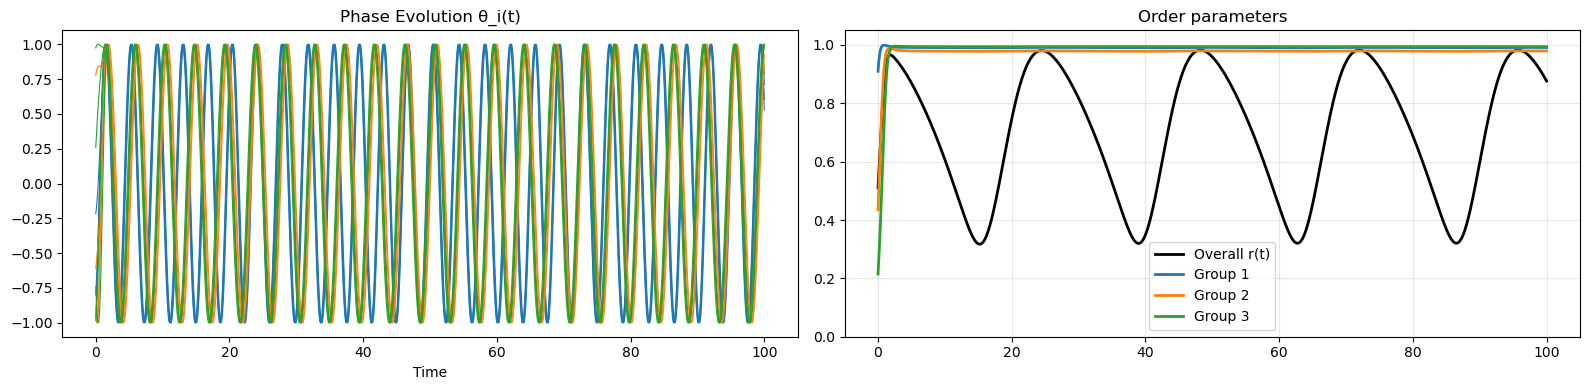

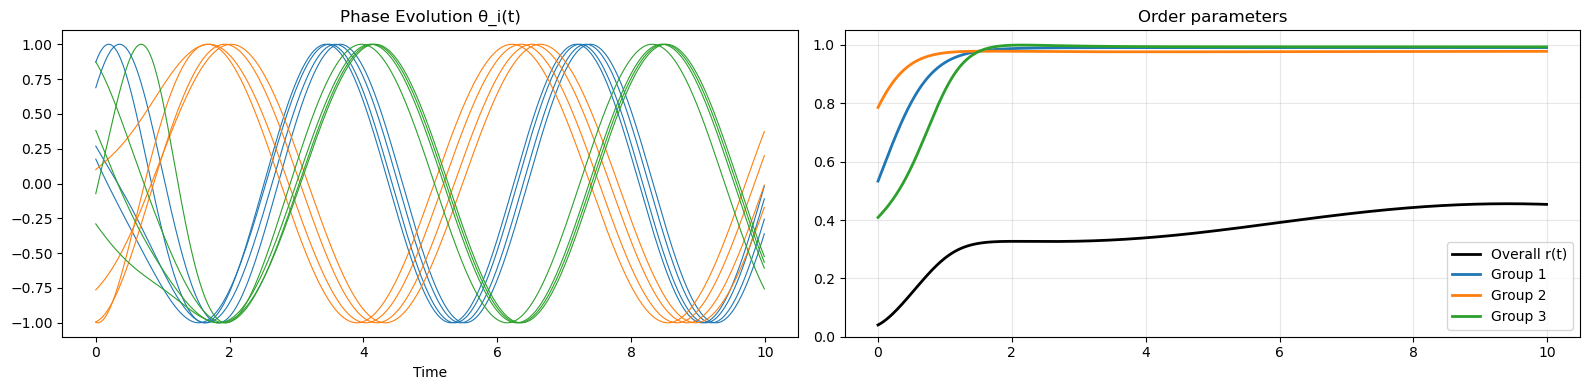

In [1]:
from deepkoop_func import Lusch
from deepkoop_func import koopman_loss,prediction_loss
from deepkoop_func import prepare_dataloader, create_sequences
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from data_func import plot_clustered_kuramoto

def get_device(force_cpu=False):
    """
    获取计算设备 (Device)。
    优先顺序: MPS (Mac) > CUDA (Nvidia) > CPU
    
    Args:
        force_cpu (bool): 如果为 True，强制使用 cpu
    Returns:
        torch.device
    """
    if force_cpu:
        device = torch.device("cpu")
    elif torch.backends.mps.is_available():
        # 检测 macOS 的 Metal Performance Shaders (M1/M2/M3 chips)
        device = torch.device("mps")
    elif torch.cuda.is_available():
        # 为了代码兼容性，顺便加上 CUDA 检测
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
        
    return device

N=12
n_clusters=3  # 团数
K_intra=5
K_inter=0.1
noise=0
dt=0.01
x_train, theta_hist, t_train, _ = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=100,
    random_seed1=0, random_seed2=0,
    dt=dt
)

x_test, theta_hist, t_test, _ = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=10,
    random_seed1=0, random_seed2=5,
    dt=dt
)



100%|██████████| 8/8 [00:00<00:00, 75.15it/s]



 ==========  EPOCH 0  ==========

Prediction Loss: 0.4981
TRAIN LOSS:  1.1358669325709343
TEST LOSS:  0.9677745550870895


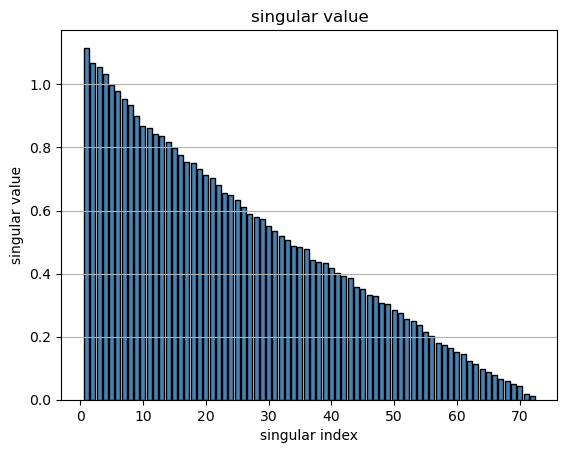

100%|██████████| 8/8 [00:00<00:00, 75.29it/s]



 ==========  EPOCH 10  ==========

Prediction Loss: 0.7985
TRAIN LOSS:  0.21452818252146244
TEST LOSS:  0.23806297406554222


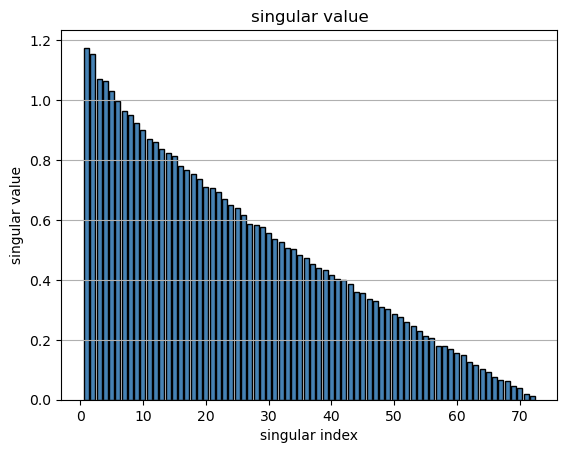

100%|██████████| 8/8 [00:00<00:00, 70.11it/s]



 ==========  EPOCH 20  ==========

Prediction Loss: 0.9938
TRAIN LOSS:  0.16451114742085338
TEST LOSS:  0.1700110975652933


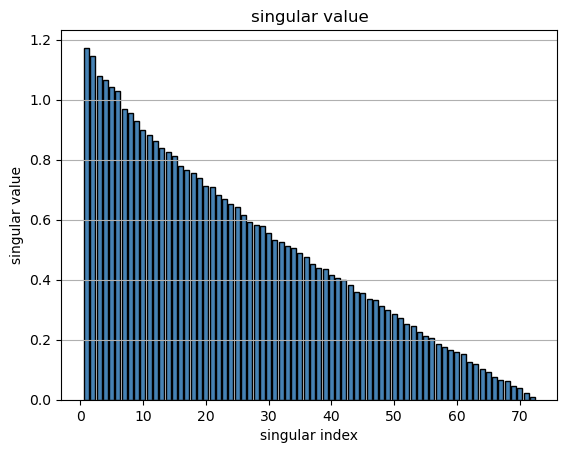

100%|██████████| 8/8 [00:00<00:00, 74.50it/s]



 ==========  EPOCH 30  ==========

Prediction Loss: 0.7021
TRAIN LOSS:  0.09468427975662053
TEST LOSS:  0.11784707568585873


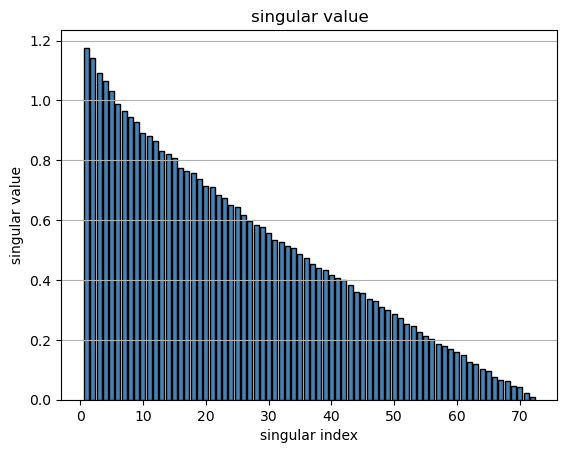

100%|██████████| 8/8 [00:00<00:00, 75.39it/s]



 ==========  EPOCH 40  ==========

Prediction Loss: 0.6685
TRAIN LOSS:  0.04000374610768631
TEST LOSS:  0.04524112120270729


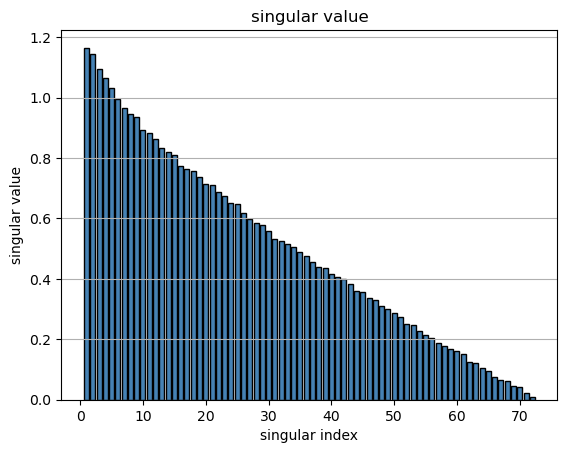

100%|██████████| 8/8 [00:00<00:00, 75.15it/s]



 ==========  EPOCH 50  ==========

Prediction Loss: 0.6825
TRAIN LOSS:  0.03130053388304077
TEST LOSS:  0.03704761900007725


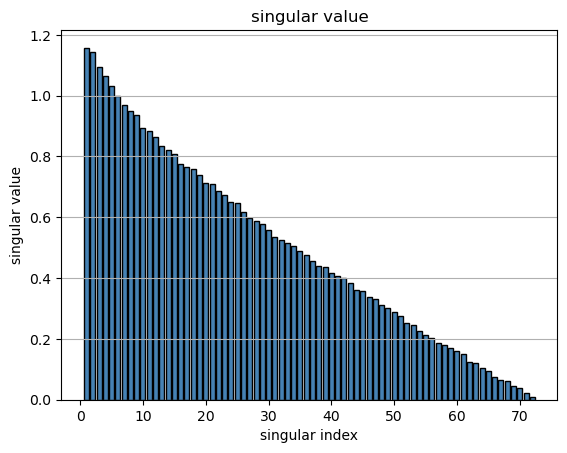

100%|██████████| 8/8 [00:00<00:00, 76.10it/s]



 ==========  EPOCH 60  ==========

Prediction Loss: 0.6808
TRAIN LOSS:  0.028331814071862027
TEST LOSS:  0.034080891869962215


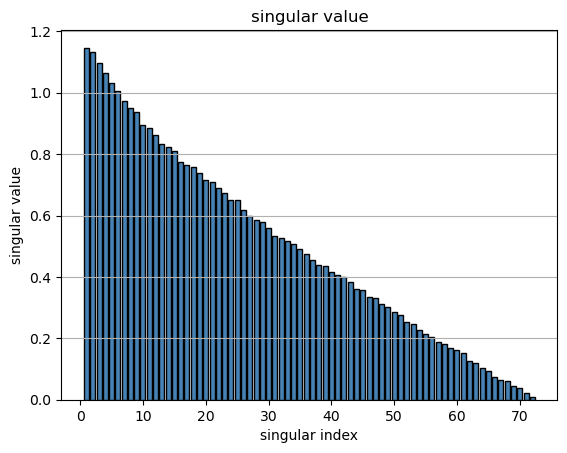

100%|██████████| 8/8 [00:00<00:00, 74.94it/s]



 ==========  EPOCH 70  ==========

Prediction Loss: 0.6979
TRAIN LOSS:  0.042149170592892915
TEST LOSS:  0.03215525299310684


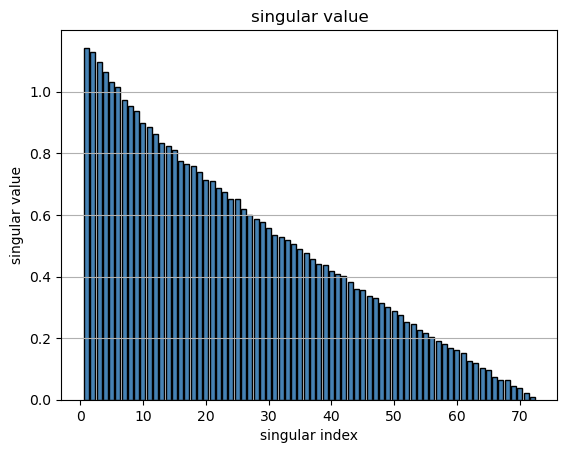

100%|██████████| 8/8 [00:00<00:00, 76.00it/s]



 ==========  EPOCH 80  ==========

Prediction Loss: 0.6879
TRAIN LOSS:  0.019447951330221258
TEST LOSS:  0.023684993153437972


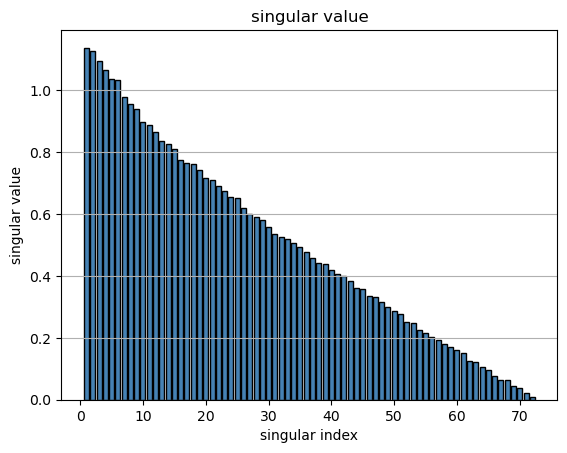

100%|██████████| 8/8 [00:00<00:00, 71.17it/s]



 ==========  EPOCH 90  ==========

Prediction Loss: 0.6568
TRAIN LOSS:  0.013523765563149936
TEST LOSS:  0.01333170325960964


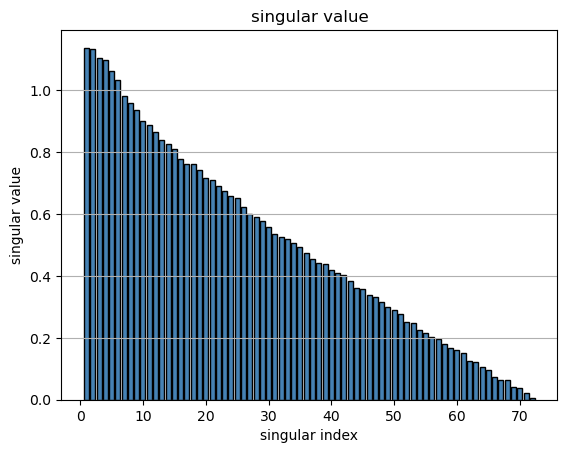

100%|██████████| 8/8 [00:00<00:00, 72.43it/s]



 ==========  EPOCH 100  ==========

Prediction Loss: 0.6551
TRAIN LOSS:  0.008859975467203185
TEST LOSS:  0.01184523943811655


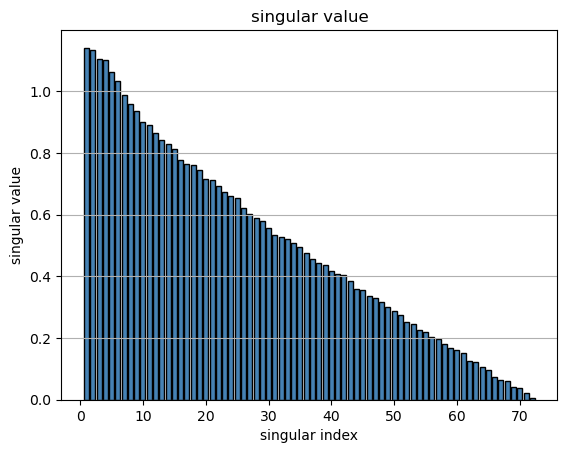

100%|██████████| 8/8 [00:00<00:00, 71.60it/s]



 ==========  EPOCH 110  ==========

Prediction Loss: 0.6582
TRAIN LOSS:  0.012004950549453497
TEST LOSS:  0.01332257257308811


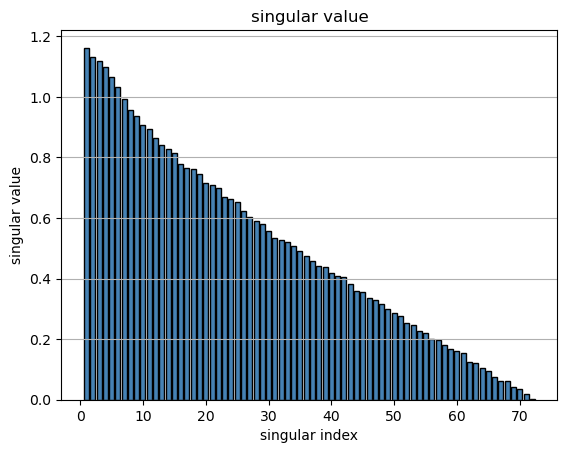

100%|██████████| 8/8 [00:00<00:00, 71.98it/s]


In [9]:
koopman_dim = 72
# encoder dim
hidden_dim = 512
input_dim = 24

epochs = 120
lr = 1e-3
Sp = 72; horizon = 72; T = max(horizon,Sp)
batch_size = 256
alpha1=2
alpha2=1e-8
alpha_CE=0
device = get_device(force_cpu=False)

model = Lusch(input_dim,koopman_dim,hidden_dim = hidden_dim,delta_t=dt,device=device).to(device=device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

train_loader, val_loader = prepare_dataloader(x_train, T, batch_size=batch_size)
x_train_dims = create_sequences(x_train,T+1)
x_test_dims = create_sequences(x_test,T+1)
X_train_recon = x_train_dims[:,:-T,:]; X_test_recon = x_test_dims[:,:-T,:]
X_forecast_train = x_train_dims[:,-T:,:]; X_forecast_test = x_test_dims[:,-T:,:]

# model.mu = train_loader.dataset.mu.to(device)
# model.std = train_loader.dataset.std.to(device)

for epoch in range(0, epochs):
    train_epoch_loss = []
    test_epoch_loss = []

    model.train()
    for (x,) in tqdm(train_loader):
        optimizer.zero_grad()
        loss_train = koopman_loss(x.to(device=device), model, Sp=Sp, T=T, alpha1=alpha1, alpha2=alpha2, alpha_CE=alpha_CE)
        loss_train.backward()
        optimizer.step()
        train_epoch_loss.append(loss_train.item())

    with torch.no_grad():
        model.eval()
        for (x,) in tqdm(val_loader):
            loss_test = koopman_loss(x.to(device=device), model, Sp=Sp, T=T, alpha1=alpha1, alpha2=alpha2, alpha_CE=alpha_CE)
            test_epoch_loss.append(loss_test.cpu().item())

        forecast_loss = prediction_loss(X_test_recon[:,[-1],:].to(device=device), X_forecast_test.to(device=device),model)

    if epoch % 10 == 0:
        print("\n","="*10,f" EPOCH {epoch} ","="*10)
        print("\nPrediction Loss: {:.4f}".format(forecast_loss))
        # print("Reconstruction Loss: {:.4f}".format(reconstruction_loss))
        print("TRAIN LOSS: ",np.sum(train_epoch_loss)/len(train_epoch_loss))
        print("TEST LOSS: ",np.sum(test_epoch_loss)/len(test_epoch_loss))
        K = model.koopman.linear_evolution.weight.cpu().data.numpy()
        U,S,V = np.linalg.svd(K)
        plt.figure()
        plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
        plt.grid(True, axis='y')         
        plt.xlabel('singular index')
        plt.ylabel('singular value')
        plt.title('singular value')
        plt.show()

In [6]:
x.to(device=device)

tensor([[[ 0.4894,  0.6994,  0.6148,  ...,  0.4571,  0.5009,  0.2741],
         [ 0.4741,  0.6868,  0.6009,  ...,  0.4449,  0.4891,  0.2610],
         [ 0.4587,  0.6740,  0.5869,  ...,  0.4327,  0.4771,  0.2478],
         ...,
         [-0.6501, -0.4325, -0.5300,  ..., -0.4616, -0.4170, -0.6256],
         [-0.6633, -0.4482, -0.5447,  ..., -0.4737, -0.4294, -0.6362],
         [-0.6762, -0.4637, -0.5592,  ..., -0.4857, -0.4416, -0.6467]],

        [[ 0.2977,  0.5354,  0.4374,  ...,  0.3061,  0.3532,  0.1139],
         [ 0.2810,  0.5206,  0.4217,  ...,  0.2931,  0.3404,  0.1004],
         [ 0.2643,  0.5056,  0.4058,  ...,  0.2800,  0.3276,  0.0868],
         ...,
         [-0.7935, -0.6104, -0.6944,  ..., -0.6000, -0.5596, -0.7443],
         [-0.8039, -0.6241, -0.7069,  ..., -0.6109, -0.5708, -0.7533],
         [-0.8142, -0.6376, -0.7191,  ..., -0.6216, -0.5820, -0.7622]],

        [[ 0.6577,  0.4318,  0.5331,  ...,  0.9333,  0.9503,  0.8437],
         [ 0.6704,  0.4472,  0.5474,  ...,  0

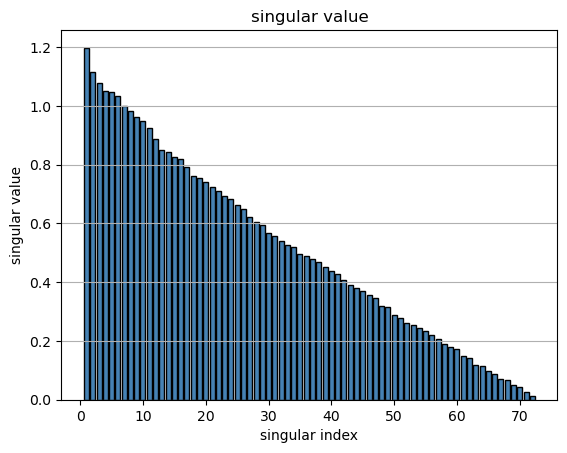

In [6]:
K = model.koopman.linear_evolution.weight.cpu().data.numpy()
U,S,V = np.linalg.svd(K)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

15min25s

# 符号回归

In [4]:
import numpy as np
import torch
from pysr import PySRRegressor

# ==========================================
# 1. 准备训练数据
# ==========================================
# 我们需要从训练好的模型中采样一批输入输出对
# 为了提高回归质量，建议采样覆盖整个相空间的点

def sample_model_io(model, dataloader, num_samples=2000):
    model.eval()
    device = next(model.parameters()).device
    
    X_input_list = []
    G_latent_list = []
    Omega_list = [] # 动力学参数
    
    count = 0
    with torch.no_grad():
        for batch_x in dataloader:
            x = batch_x[0].to(device) # [B, T, D]
            # 我们只取 t=0 时刻的状态进行映射分析
            x0 = x[:, 0, :]
            
            # 1. 获取 Latent State (Encoder)
            g = model.encoder(x0)
            
            # 2. 获取 Dynamics Params (Omega Nets)
            # omegas 是一个 list，我们需要把它展平成一个向量
            omegas = model.get_omegas(g)
            # 展平处理: omegas 包含 [Batch, 2] (complex) 和 [Batch, 1] (real)
            # 我们将其拼接成 [Batch, n_params]
            omega_flat = torch.cat(omegas, dim=1)
            
            X_input_list.append(x0.cpu().numpy())
            G_latent_list.append(g.cpu().numpy())
            Omega_list.append(omega_flat.cpu().numpy())
            
            count += x0.shape[0]
            if count >= num_samples:
                break
                
    X_data = np.concatenate(X_input_list, axis=0)[:num_samples]
    G_data = np.concatenate(G_latent_list, axis=0)[:num_samples]
    Omega_data = np.concatenate(Omega_list, axis=0)[:num_samples]
    
    return X_data, G_data, Omega_data

print("Sampling data from trained model...")
# 假设 train_loader 已经在上下文中
X_np, G_np, Omega_np = sample_model_io(model, train_loader, num_samples=3000)
print(f"Sampled shapes: X={X_np.shape}, G={G_np.shape}, Omega={Omega_np.shape}")

# ==========================================
# 2. 配置 PySR
# ==========================================
default_pysr_params = dict(
    populations=40,
    model_selection="best",
    niterations=40, # 迭代次数越多越精确，但越慢
    # 选择适合动力系统的算子
    binary_operators=["+", "-", "*", "/"],
    unary_operators=[
        "cos", "sin", "square", "cube"
        # "exp", "tanh" # 根据需要开启，Kuramoto 主要是三角函数
    ],
    maxsize=25, # 限制公式复杂度
    verbosity=0,
    procs=4, # 并行核心数
)

# ==========================================
# 3. 任务 A: 提取 Encoder (X -> G)
# ==========================================
print("\n=== 1. Symbolic Regression for ENCODER (x -> g) ===")
# 我们通常逐维度回归，因为每个 latent dimension 可能由不同的物理量组成
# 输入: 观测状态 X_np (例如 8维: cos1, sin1, cos2, sin2...)
# 输出: 潜在状态 G_np (例如 6维)

encoder_eqs = []
latent_dim = G_np.shape[1]

for i in range(latent_dim):
    print(f"--- Fitting Latent Dimension g_{i} ---")
    model_sr = PySRRegressor(**default_pysr_params)
    model_sr.fit(X_np, G_np[:, i])
    
    eq = model_sr.sympy()
    encoder_eqs.append(eq)
    print(f"g_{i} = {eq}")

# ==========================================
# 4. 任务 B: 提取 Dynamics (G -> Omega/K)
# ==========================================
print("\n=== 2. Symbolic Regression for DYNAMICS (Auxiliary Nets: g -> omega) ===")
# 输入: 潜在状态 r^2 (DeepKoopman 结构中辅助网络输入的是半径平方) 或直接用 g
# 注意: 在 DeepKoopman 代码中，辅助网络的输入比较特殊：
# - 复数对的辅助网络输入是 r^2 = g_2k^2 + g_{2k+1}^2
# - 实数的辅助网络输入是 g_k
# 为了发现最原本的规律，我们直接尝试拟合 g -> omega 参数

dynamics_eqs = []
num_params = Omega_np.shape[1]

for i in range(num_params):
    print(f"--- Fitting Dynamics Parameter p_{i} (Freq/Growth) ---")
    # 这里我们只用相关的 latent variable 可能会更好，但全输入通用性更强
    model_sr = PySRRegressor(**default_pysr_params)
    model_sr.fit(G_np, Omega_np[:, i])
    
    eq = model_sr.sympy()
    dynamics_eqs.append(eq)
    print(f"param_{i} = {eq}")

# ==========================================
# 5. 任务 C: 提取 Decoder (G -> X)
# ==========================================
print("\n=== 3. Symbolic Regression for DECODER (g -> x) ===")
# 输入: 潜在状态 G_np
# 输出: 重构观测状态 X_np

decoder_eqs = []
input_dim = X_np.shape[1]

for i in range(input_dim):
    print(f"--- Fitting Observable Dimension x_{i} ---")
    model_sr = PySRRegressor(**default_pysr_params)
    model_sr.fit(G_np, X_np[:, i])
    
    eq = model_sr.sympy()
    decoder_eqs.append(eq)
    print(f"x_{i} = {eq}")

# ==========================================
# 6. 汇总报告
# ==========================================
print("\n" + "="*40)
print("FINAL SYMBOLIC DISCOVERY REPORT")
print("="*40)

print("\n[Encoder Functions]:")
variable_names_x = [f"x{i}" for i in range(X_np.shape[1])]
for i, eq in enumerate(encoder_eqs):
    print(f"g[{i}] = {eq}")

print("\n[Dynamics Parameters (K matrix elements)]:")
# Omega 输出解释:
# 对于复数对 j: param_2j = Frequency, param_2j+1 = Growth Rate
# 对于实数 k:   param = Growth Rate
variable_names_g = [f"g{i}" for i in range(G_np.shape[1])]
for i, eq in enumerate(dynamics_eqs):
    print(f"K_param[{i}] = {eq}")

print("\n[Decoder Functions]:")
for i, eq in enumerate(decoder_eqs):
    print(f"x[{i}] = {eq}")

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Sampling data from trained model...
Sampled shapes: X=(1592, 8), G=(1592, 6), Omega=(1592, 6)

=== 1. Symbolic Regression for ENCODER (x -> g) ===
--- Fitting Latent Dimension g_0 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


g_0 = (x4 + x7/1.7143139)/0.9589132 - 0.36004773*x3/cos((x7*1.3247957 + (x4 + x7)*(-0.39080334))**2)
--- Fitting Latent Dimension g_1 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


g_1 = (x4 - 2.423522*(x5 + sin(x1 + 0.027022216)*0.14078456))/1.2337226
--- Fitting Latent Dimension g_2 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


g_2 = sin(x3 - (x0 + x0 + x2*(-0.8104002) + (x3 - x4)*0.3683622 + 0.125642))*(-0.29554492) - 0.04098106
--- Fitting Latent Dimension g_3 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


g_3 = (x4*(-0.049214736)*x3 - 0.35229418)*(x4 + x7*(-0.61742514) - 0.04523233)
--- Fitting Latent Dimension g_4 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


g_4 = sin((0.013369621 + (-x6 + x7)**3/(x2 - 1*(-0.1041942)))*(x0 + x6))*1.6080958
--- Fitting Latent Dimension g_5 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


g_5 = (x1*(-1.1409711) + x3 - 0.57310545*x7 + 0.03181894)/(-1.0778168)

=== 2. Symbolic Regression for DYNAMICS (Auxiliary Nets: g -> omega) ===
--- Fitting Dynamics Parameter p_0 (Freq/Growth) ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


param_0 = -x3*x4*(x2**3 - 1.7770249*x3*cos(x1)) + x5*0.0051761563 + 1.4863248
--- Fitting Dynamics Parameter p_1 (Freq/Growth) ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


param_1 = (-(x2*0.021295892 + cos(x5*(-0.7758558))) - sin(cos(x3)) + 1.9235444)*cos(x5)
--- Fitting Dynamics Parameter p_2 (Freq/Growth) ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


param_2 = sin(sin(x3**2*0.2746584 - sin(cos(x2)))) - 1*0.01927425
--- Fitting Dynamics Parameter p_3 (Freq/Growth) ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


param_3 = (-(-0.0699505)*x4 + (x0*(x0 + x1*cos(x1) + 0.3630852) + x2)*0.005380023 - 0.5368751)**3
--- Fitting Dynamics Parameter p_4 (Freq/Growth) ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


param_4 = -x4*((x4 - 0.134215136082746*cos(cos(x3 + x4 - 1*0.20970994))**2)*(-0.08498309) - 0.28982386) - 1.0418518
--- Fitting Dynamics Parameter p_5 (Freq/Growth) ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


param_5 = (sin(x5*0.37000087) + 0.12305131)*sin(cos(sin(sin(x5*(-0.33100137)))))*cos(sin(sin(sin(x5*(-0.3441142)))))

=== 3. Symbolic Regression for DECODER (g -> x) ===
--- Fitting Observable Dimension x_0 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_0 = (-sin(x3 - x4)**2 - 0.6758578)*(x1 + x2 + x5*(-1.3602179) - 0.018968044)
--- Fitting Observable Dimension x_1 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_1 = 0.0030615632 + (x0*sin(x5)**2 + x0/0.601735 + x1 + x3)*(-0.31094787)
--- Fitting Observable Dimension x_2 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_2 = x0*(-0.3904265) + x1*(-0.47137025) - 0.42704773*x3 + (0.1785664 - x3)**4
--- Fitting Observable Dimension x_3 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_3 = x3**3 - (x1*0.48017624 + x4*(-0.18725275) - (x0*(-0.26130447) - x5)) - 0.03190909
--- Fitting Observable Dimension x_4 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_4 = ((x4 + sin(x1)*sin(x0 - 1*(-0.47451568)))*x2*(-0.16185784) + x2 - (-1.3838667)*(x0 - x4))*0.40229416
--- Fitting Observable Dimension x_5 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_5 = -x5 + (1.3278658 - sin(x1*(x3 + x4))**2)*(x2*4.4501247/(1.5223136 - (-16.951786)*x2*x5) - x3)
--- Fitting Observable Dimension x_6 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_6 = x0*0.07773491 - 0.3878803*(x1 - (x0 - x2 + (x5 + sin(x4*(-1.0066168)))/(-3.1632187))) - 0.009709233
--- Fitting Observable Dimension x_7 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


x_7 = (x0*0.7434895 + sin(x1*(-0.24936023) + x3 + x4 - x5 - 0.04122119))*0.7586983

FINAL SYMBOLIC DISCOVERY REPORT

[Encoder Functions]:
g[0] = (x4 + x7/1.7143139)/0.9589132 - 0.36004773*x3/cos((x7*1.3247957 + (x4 + x7)*(-0.39080334))**2)
g[1] = (x4 - 2.423522*(x5 + sin(x1 + 0.027022216)*0.14078456))/1.2337226
g[2] = sin(x3 - (x0 + x0 + x2*(-0.8104002) + (x3 - x4)*0.3683622 + 0.125642))*(-0.29554492) - 0.04098106
g[3] = (x4*(-0.049214736)*x3 - 0.35229418)*(x4 + x7*(-0.61742514) - 0.04523233)
g[4] = sin((0.013369621 + (-x6 + x7)**3/(x2 - 1*(-0.1041942)))*(x0 + x6))*1.6080958
g[5] = (x1*(-1.1409711) + x3 - 0.57310545*x7 + 0.03181894)/(-1.0778168)

[Dynamics Parameters (K matrix elements)]:
K_param[0] = -x3*x4*(x2**3 - 1.7770249*x3*cos(x1)) + x5*0.0051761563 + 1.4863248
K_param[1] = (-(x2*0.021295892 + cos(x5*(-0.7758558))) - sin(cos(x3)) + 1.9235444)*cos(x5)
K_param[2] = sin(sin(x3**2*0.2746584 - sin(cos(x2)))) - 1*0.01927425
K_param[3] = (-(-0.0699505)*x4 + (x0*(x0 + x1*cos(x1) + 0.363